In [1]:
using MAT
using NPZ
using Pkg
using Glob
using WebIO
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using DelimitedFiles

pkgs = Pkg.installed();
pkgs["Eirene"]

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-221982640285821583\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4595623233733274446\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-221982640285821583\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

v"1.3.3"

#### Helper functions

In [2]:
function getdata(positionfilename, typesfilename)
    posarray = readdlm(positionfilename, ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        posarray[j] = chop(posarray[j]);
        xsign = 1;
        x_y = split(posarray[j], '-');
        if(x_y[1] == "")
            xsign = -1;
            x_y = deleteat!(x_y,1);
        end
        x_plus_y = [];
        if(size(x_y)[1] == 1)
            x_plus_y = split(posarray[j], '+');
            x_plus_y = map(a->parse(Float64,a),x_plus_y);
            push!(posx, x_plus_y[1]);
            push!(posy, x_plus_y[2]);
        else
            x_y = map(a->parse(Float64,a),x_y);
            x_y[1] *= xsign;
            x_y[2] *= -1;
            push!(posx,x_y[1]);
            push!(posy,x_y[2]);
        end
    end
    typesarray = readdlm(typesfilename, ',','\n');
    typesarray = Array{Int64,2}(typesarray)
    positions = transpose(hcat(posx, posy))
    return (positions, typesarray);
end

function getalldatafortype(typeofsimunderscore, numberofsim)
    totaldata = []
    for i in 1:numberofsim
        foldername = string("DAH_",typeofsimunderscore, "_",i);
        filename = string(foldername , "/Pos_1000000.dat");
        typefilename = string(foldername,  "/Types_1000000.dat");
        (a,b) = getdata(filename,typefilename);
        push!(totaldata, (a,b));
    end
    return totaldata;
end

function gettypeseparateddata(data,typedata,typesarray)
    results = []
    for i in 1:size(typesarray,1)
        iindices = findall(x->x == typesarray[i], typedata);
        actualindices = getindex.(iindices, [1]);
        datawheni = data[:,actualindices]
        push!(results,datawheni)
    end
    return results
end

function separatedataforall(totaldata, typearray)
    separateddata1 = Dict{Int64, Array{Float64,2}}();
    separateddata2 = Dict{Int64, Array{Float64,2}}();
    for i = 1:size(totaldata,1)
        (togetherdata, types) = totaldata[i];
        cell1, cell2 = gettypeseparateddata(togetherdata, types,typearray);
        push!(separateddata1,i => cell1)
        push!(separateddata2, i => cell2)
    end
    return separateddata1, separateddata2
end

function wassersteinfromdiagram(complete, lipid, twophase)
    alltogetherinorder = Array{ Dict{String,Any}}(undef, 15, 1);
    wassersteindistances = Array{Float64}(undef,15,15);
    for i in 1:5
        alltogetherinorder[i] = complete[i];
        alltogetherinorder[i+5] = lipid[i];
        alltogetherinorder[i+10] = twophase[i];
    end
    for j in 1:15
        for k in 1:15
            currentbarcode = barcode(alltogetherinorder[j], dim=1);
            otherbarcode = barcode(alltogetherinorder[k], dim=1);
            wassersteindistances[j,k] = wasserstein_distance(currentbarcode, otherbarcode, q=2, p=2);
        end
    end
    return wassersteindistances;
end

wassersteinfromdiagram (generic function with 1 method)

In [3]:
completesortdata = getalldatafortype("Complete_Sorting", 5);
lipidbilayerdata = getalldatafortype("Lipid_Bilayer", 5);
twophasedata = getalldatafortype("Two_Phase", 5);

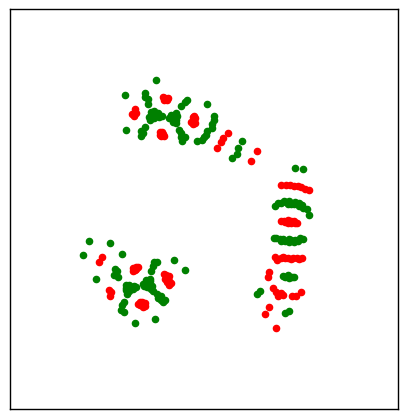

In [4]:
sim_num = 1
xdat = lipidbilayerdata[sim_num][1][1,:]
ydat = lipidbilayerdata[sim_num][1][2,:]
xytype = lipidbilayerdata[sim_num][2] 

figure(figsize=(5,5))
for cnt in range(1, stop=length(xytype))
    if xytype[cnt] == 1
        scatter(xdat[cnt], ydat[cnt], color="red")
    else
        scatter(xdat[cnt], ydat[cnt], color="green")
    end
end
xlim([-10, 10])
ylim([-10, 10])
xticks([]);
yticks([]);

In [5]:
completesort1, completesort2 = separatedataforall(completesortdata, [1,2]);
lipid1, lipid2 = separatedataforall(lipidbilayerdata, [1,2]);
twophase1, twophase2 = separatedataforall(twophasedata, [1,2]);

In [6]:
completecell1diagrams = Dict{Int64, Dict{String,Any}}();
lipidcell1diagrams = Dict{Int64, Dict{String,Any}}();
twophasecell1diagrams = Dict{Int64, Dict{String,Any}}();

completecell2diagrams = Dict{Int64, Dict{String,Any}}();
lipidcell2diagrams = Dict{Int64, Dict{String,Any}}();
twophasecell2diagrams = Dict{Int64, Dict{String,Any}}();

completeallcell = Dict{Int64, Dict{String,Any}}();
lipidallcell = Dict{Int64, Dict{String,Any}}();
twophaseallcell = Dict{Int64, Dict{String,Any}}();

for j = 1:5
    compdiagram = eirene(completesort1[j], model = "pc", maxdim = 1, maxrad = 10, record="none");  
    lipiddiagram = eirene(lipid1[j], model = "pc", maxdim = 1, maxrad = 10, record="none"); 
    twophasediagram = eirene(twophase1[j], model = "pc", maxdim = 1, maxrad = 10, record="none"); 
    push!(completecell1diagrams, j=>compdiagram);
    push!(lipidcell1diagrams, j=>lipiddiagram);
    push!(twophasecell1diagrams, j=>twophasediagram);
end

for j = 1:5
    compdiagram = eirene(completesort2[j], model = "pc", maxdim = 1, maxrad = 10, record="none");  
    lipiddiagram = eirene(lipid2[j], model = "pc", maxdim = 1, maxrad = 10, record="none"); 
    twophasediagram = eirene(twophase2[j], model = "pc", maxdim = 1, maxrad = 10, record="none"); 
    push!(completecell2diagrams, j=>compdiagram);
    push!(lipidcell2diagrams, j=>lipiddiagram);
    push!(twophasecell2diagrams, j=>twophasediagram);
end

for i = 1:5
    compdiagram = eirene(completesortdata[i][1], model = "pc", maxdim = 1, maxrad = 10, record="none");  
    lipiddiagram = eirene(lipidbilayerdata[i][1], model = "pc", maxdim = 1, maxrad = 10, record="none"); 
    twophasediagram = eirene(twophasedata[i][1], model = "pc", maxdim = 1, maxrad = 10, record="none"); 
    push!(completeallcell, i=>compdiagram);
    push!(lipidallcell, i=>lipiddiagram);
    push!(twophaseallcell, i=>twophasediagram);
end

In [7]:
celltype1wasserstein = wassersteinfromdiagram(completecell1diagrams, lipidcell1diagrams, twophasecell1diagrams);

In [8]:
celltype2wasserstein = wassersteinfromdiagram(completecell2diagrams, lipidcell2diagrams, twophasecell2diagrams);

In [9]:
celltogetherwasserstein = wassersteinfromdiagram(completeallcell, lipidallcell, twophaseallcell);

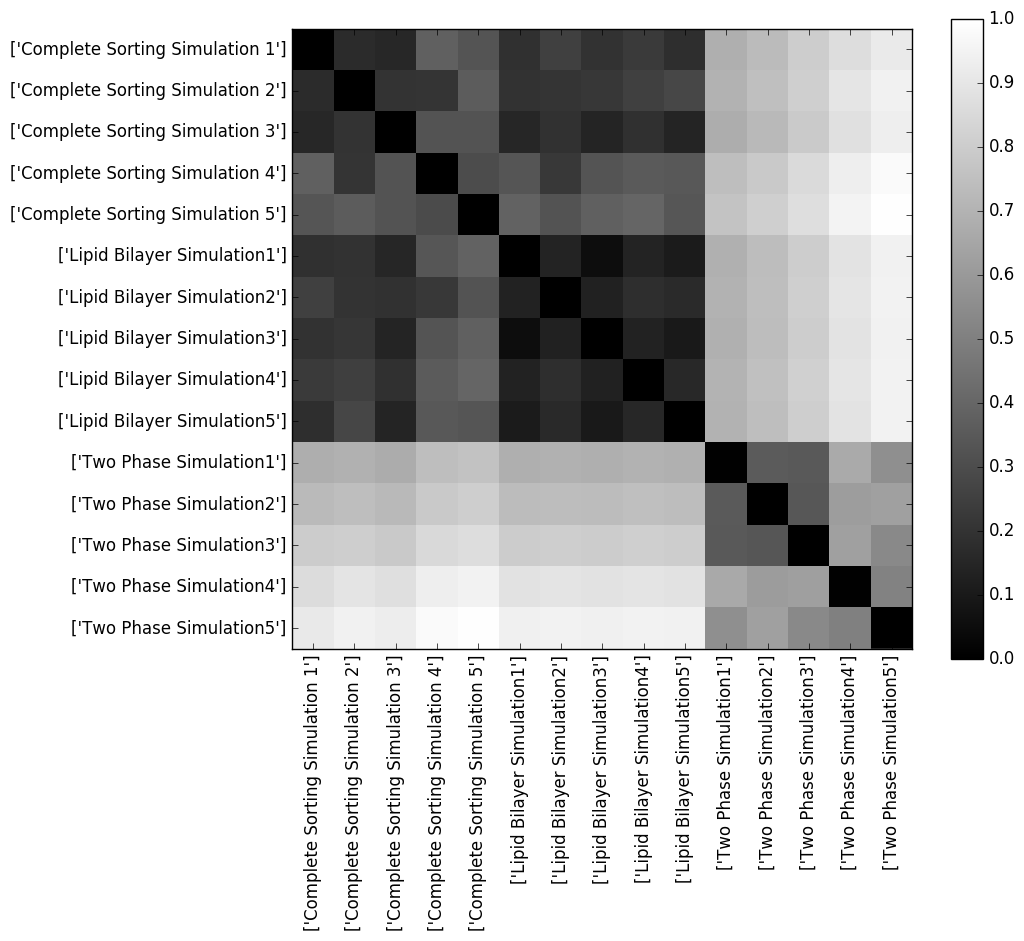

In [10]:
max_coord = maximum(celltype1wasserstein)
wassmatrix = celltype1wasserstein/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = string("Complete Sorting Simulation ",i);
        well_names[i+5] = string("Lipid Bilayer Simulation", i);
        well_names[i+10] = string("Two Phase Simulation", i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();

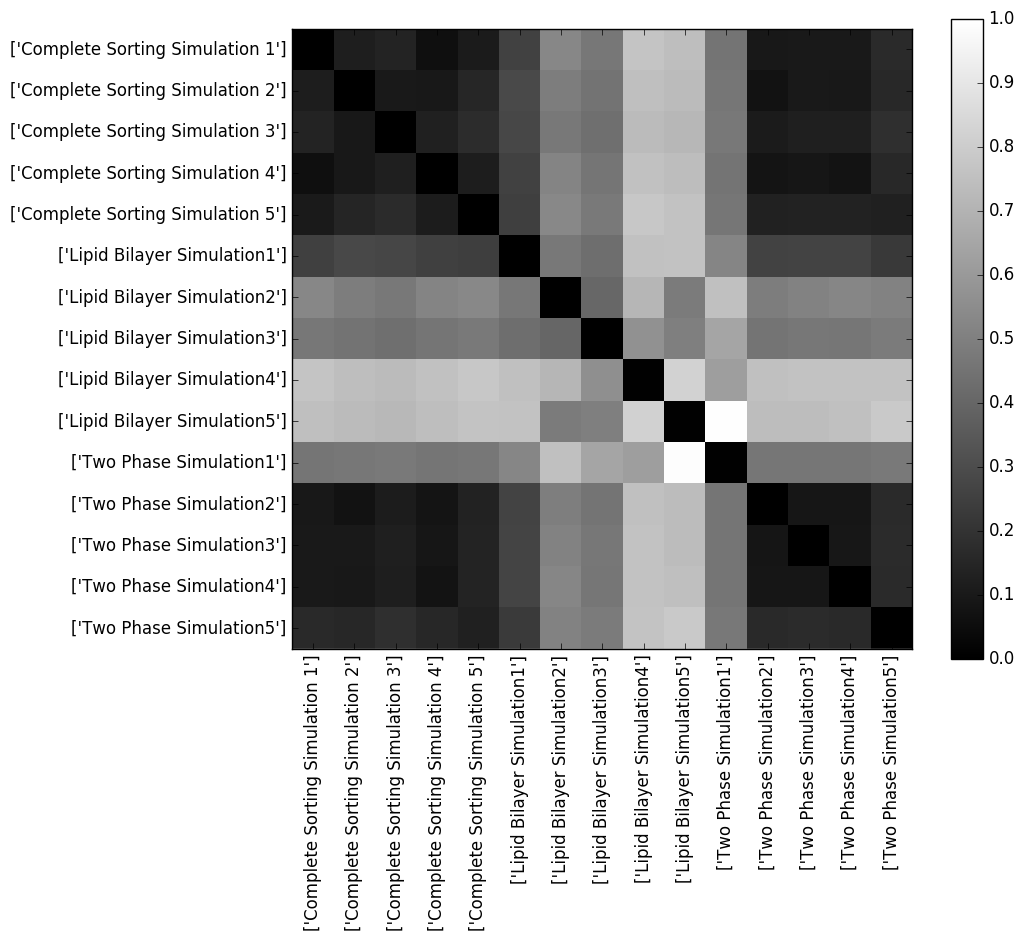

In [11]:
max_coord = maximum(celltype2wasserstein)
wassmatrix = celltype2wasserstein/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = string("Complete Sorting Simulation ",i);
        well_names[i+5] = string("Lipid Bilayer Simulation", i);
        well_names[i+10] = string("Two Phase Simulation", i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();

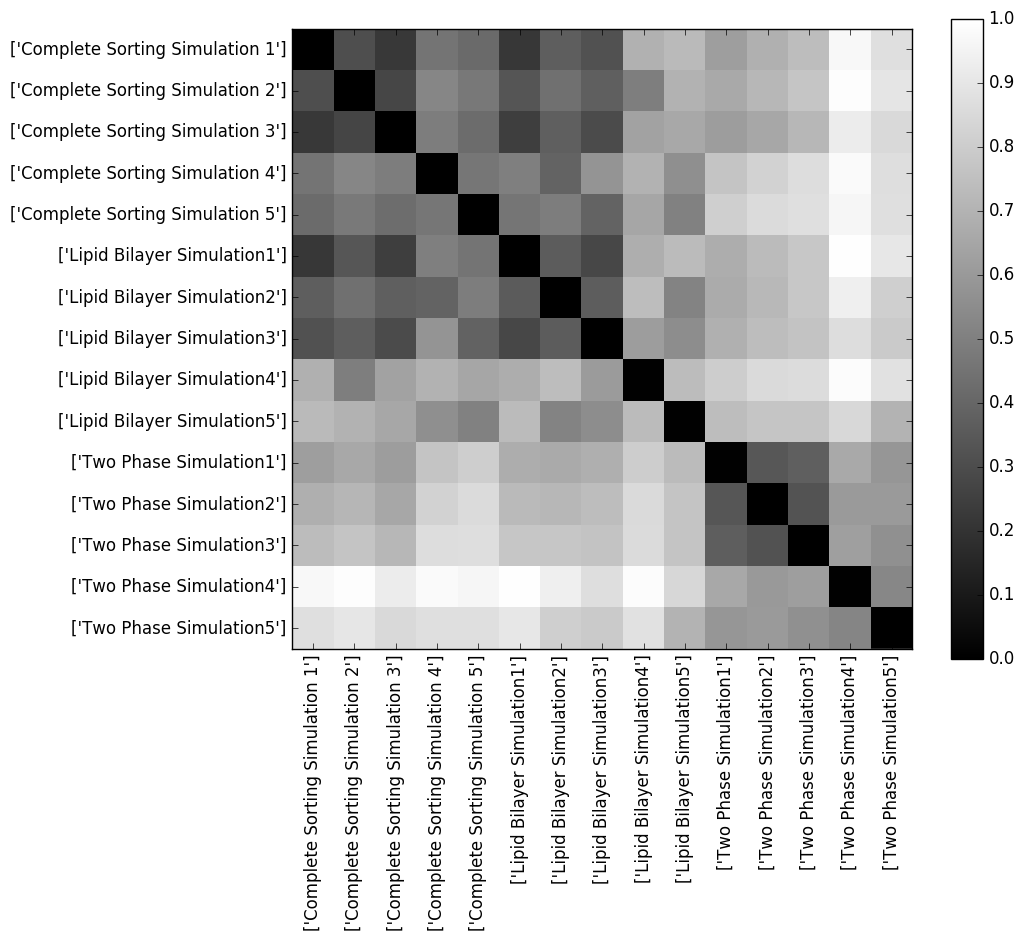

In [12]:
max_coord = maximum(celltogetherwasserstein)
wassmatrix = celltogetherwasserstein/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = "Complete Sorting Simulation "*string(i);
        well_names[i+5] = "Lipid Bilayer Simulation"* string(i);
        well_names[i+10] = "Two Phase Simulation"* string(i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();

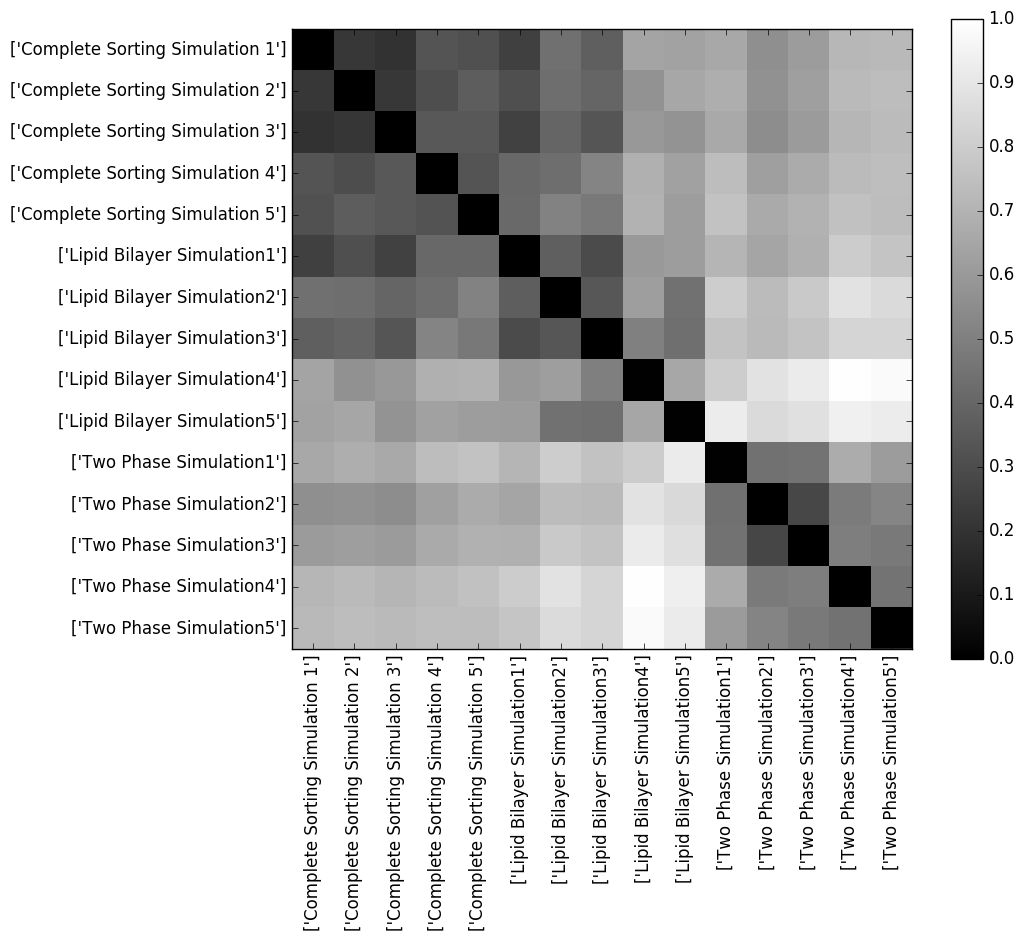

In [13]:
summatrix = celltogetherwasserstein + celltype2wasserstein + celltype1wasserstein;
max_coord = maximum(summatrix)
wassmatrix = summatrix/max_coord

well_names = Array{String}(undef, 15,1);
for i in 1:5
        well_names[i] = "Complete Sorting Simulation "*string(i);
        well_names[i+5] = "Lipid Bilayer Simulation"* string(i);
        well_names[i+10] = "Two Phase Simulation"* string(i);
end

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:14, well_names, rotation=90);
yticks(0:14, well_names);
colorbar();